In [1]:
import matplotlib.pyplot as plt
from maploc.demo import Demo, read_input_image
from maploc.utils.geo import BoundaryBox, Projection
from maploc.osm.viz import GeoPlotter
from maploc.osm.tiling import TileManager
from maploc.osm.viz import Colormap, plot_nodes
from maploc.utils.viz_2d import plot_images
from maploc.utils.viz_localization import (
    likelihood_overlay,
    plot_dense_rotations,
    add_circle_inset,
)
from maploc.utils.viz_2d import features_to_RGB
from maploc.osm.tiling import TileManager
import csv
import math
from time import time
import pandas as pd
import numpy as np

Loaded as API: https://jinlinyi-perspectivefields.hf.space/ ✔


In [2]:
demo = Demo(num_rotations=128, device='cuda')

/root/.virtualenvs/OrienterNet/lib/python3.10/site-packages/torch/overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
/root/.virtualenvs/OrienterNet/lib/python3.10/site-packages/torch/overrides.py:111: UserWarning: 'has_cudnn' is deprecated, please use 'torch.backends.cudnn.is_available()'
  torch.has_cudnn,
/root/.virtualenvs/OrienterNet/lib/python3.10/site-packages/torch/overrides.py:117: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps,
/root/.virtualenvs/OrienterNet/lib/python3.10/site-packages/torch/overrides.py:118: UserWarning: 'has_mkldnn' is deprecated, please use 'torch.backends.mkldnn.is_available()'
  torch.has_mkldnn,


In [3]:
def haversine(lat1, lon1, lat2, lon2):
    # Umwandlung von Grad in Radianten
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])

    # Haversine-Formel
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.asin(math.sqrt(a))

    # Radius der Erde in Kilometern. Verwenden Sie 3956 für Meilen
    r = 6371000

    return c * r

In [4]:
def calc_gps(image_path, lat, long, tile_size=128):
    s = time()
    image, camera, gravity, proj, bbox, prior_latlon = read_input_image(image_path,prior_latlon=(lat, long),tile_size_meters=tile_size)
    print(f"read_input_image: {time()-s}s")
    print(camera)

    s = time()
    tiler = TileManager.from_bbox(proj, bbox + 10, demo.config.data.pixel_per_meter)
    print(f"TileManager.from_bbox: {time()-s}s")

    s = time()
    canvas = tiler.query(bbox)
    print(f"tiler.query: {time()-s}s")

    s = time()
    uv, yaw, prob, neural_map, image_rectified = demo.localize(image, camera, canvas, roll_pitch=gravity)
    print(f"localize: {time()-s}s")

    s = time()
    latlon_estimate = proj.unproject(canvas.to_xy(uv))
    print(f"unproject: {time()-s}s")
    
    lat_est = latlon_estimate[0]
    lon_est = latlon_estimate[1]
    return lat_est, lon_est

In [9]:
estimates = []
timings = []

im_cnt = 2

with open('assets/metadata.csv') as file:
    datareader = csv.reader(file)
    i = 0
    for row in datareader:
        lat, lon, im_name = row
        lat, lon = float(lat), float(lon)
        start = time()
        est_lat, est_lon = calc_gps('assets/'+im_name, lat, lon)
        timings.append(time()-start)
        diff = haversine(lat, lon, est_lat, est_lon)
        estimates.append({
            'lat': lat,
            'lon': lon,
            'diff': 0,
            'size': 2,
            'est': False
        })
        estimates.append({
            'lat': est_lat,
            'lon': est_lon,
            'diff': diff,
            'size': 5,
            'est': True
        })
        
        i += 1
        if i >= im_cnt:
            break

df = pd.DataFrame(data=estimates)
df.to_csv('first_test.csv')
print(f"gesamtzeit für {im_cnt}: {sum(timings)} avg: {sum(timings)/im_cnt}")

[2023-11-16 18:47:54 maploc INFO] Using prior latlon (52.141218556666665, 11.647478013333334).
[2023-11-16 18:47:54 maploc INFO] Calling the PerspectiveFields calibrator, this may take some time.
[2023-11-16 18:48:08 maploc INFO] Using (roll, pitch) (0.03, 0.41).
[2023-11-16 18:48:08 maploc INFO] Calling the OpenStreetMap API...


read_input_image: 14.055787324905396s
Camera torch.Size([]) torch.float64 cpu
TileManager.from_bbox: 0.6622586250305176s
tiler.query: 0.004923105239868164s
prepare data: 0.13605618476867676s
inference: 42.81625413894653s


[2023-11-16 18:48:54 maploc INFO] Using prior latlon (52.14121918666667, 11.647483031666667).
[2023-11-16 18:48:54 maploc INFO] Calling the PerspectiveFields calibrator, this may take some time.


postprocessing: 1.3436119556427002s
localize: 44.66116404533386s
unproject: 0.002162933349609375s


[2023-11-16 18:49:08 maploc INFO] Using (roll, pitch) (-0.06, 0.58).
[2023-11-16 18:49:08 maploc INFO] Calling the OpenStreetMap API...


read_input_image: 14.092709302902222s
Camera torch.Size([]) torch.float64 cpu
TileManager.from_bbox: 0.6591653823852539s
tiler.query: 0.0059051513671875s
prepare data: 0.09652543067932129s
inference: 31.9280207157135s
postprocessing: 0.7608087062835693s
localize: 33.18292474746704s
unproject: 0.0010573863983154297s
gesamtzeit für 2: 107.33333826065063 avg: 53.66666913032532


In [5]:
df = pd.read_csv('first_test.csv')

In [8]:
df

Unnamed: 0        lat        lon       diff  size    est  diff_norm
0           0  52.141219  11.647478   0.000000     2  False   0.000000
1           1  52.140412  11.647095  93.428289     5   True   1.000000
2           2  52.141219  11.647483   0.000000     2  False   0.000000
3           3  52.141096  11.646881  43.352962     5   True   0.464024

In [6]:
df['diff_norm'] = df['diff']/np.max(df['diff'])

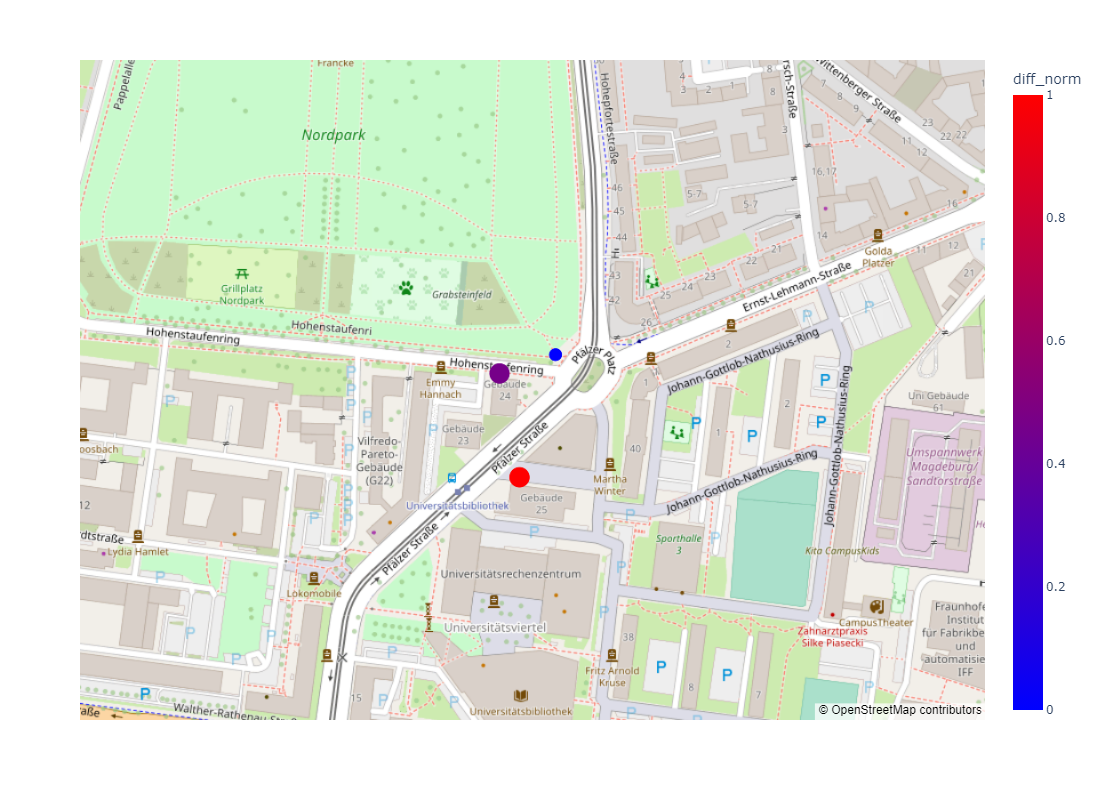

In [7]:
import plotly.express as px
##px.set_mapbox_access_token(open(".mapbox_token").read())
fig = px.scatter_mapbox(df, lat="lat", lon="lon", color="diff_norm", size="size", opacity=1,
                  color_continuous_scale=px.colors.sequential.Bluered, size_max=15, zoom=16, width=1000, height=800)
fig.update_layout(mapbox_style="open-street-map")
fig.show()